In [1]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch as ch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns

from delphi.cifar_models.resnet import resnet50
from delphi import train
from delphi.utils.constants import CIFAR_LABELS, COSINE, CYCLIC
from delphi.utils.helpers import cifar_autoaugment

In [2]:
args = Parameters({ 
    'epochs': 150,
    'num_workers': 8, 
    'batch_size': 128, 
    'lr': 1e-1, 
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 10,
    'out_dir': '/home/pstefanou/cifar-10-resnet',
    'custom_lr_multiplier': COSINE, 
    'validation_split': .8,
    'shuffle': True,
})
if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
args

{
  "epochs": 150,
  "num_workers": 8,
  "batch_size": 128,
  "lr": 0.1,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "save_ckpt_iters": 50,
  "should_save_ckpt": true,
  "log_iters": 10,
  "out_dir": "/home/pstefanou/cifar-10-resnet",
  "custom_lr_multiplier": "cosine",
  "validation_split": 0.8,
  "shuffle": true,
  "device": "cuda"
}

In [3]:
# load dataset
train_data = torchvision.datasets.CIFAR10('/home/pstefanou/', train=True, 
                                          transform=cifar_autoaugment(input_size=32, padding=4, normalize=None))
test_data = torchvision.datasets.CIFAR10('/home/pstefanou', train=False, transform=transforms.ToTensor())


# generate random indices for trianing and validation sets 
indices = list(range(len(train_data)))
split = math.floor(args.validation_split*len(train_data))
train_indices, val_indices = indices[:split], indices[split:]

# define data loaders
train_loader = DataLoader(train_data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
val_loader = DataLoader(train_data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)

test_loader = DataLoader(test_data, batch_size=args.batch_size, num_workers=args.num_workers)

# Explore Dataset


label: automobile


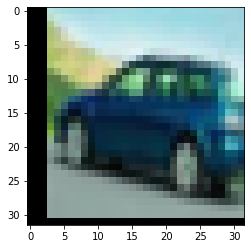

label: ship


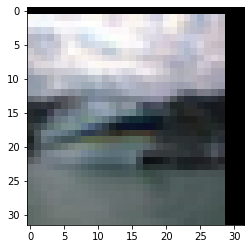

label: cat


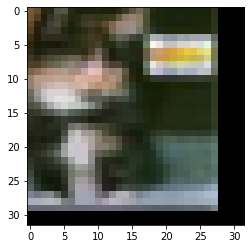

label: frog


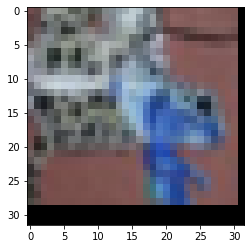

label: airplane


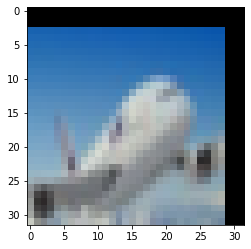

label: truck


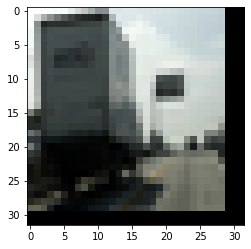

label: dog


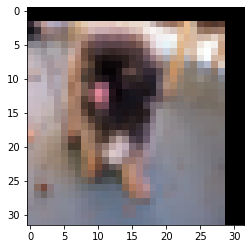

label: horse


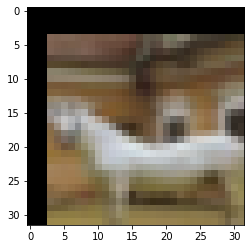

label: bird


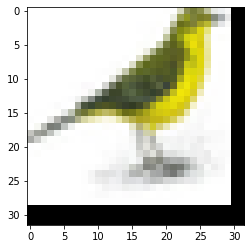

label: deer


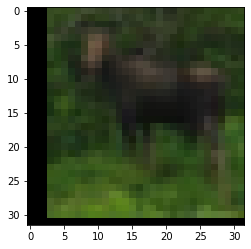

In [4]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Create Output Store

In [11]:
out_store = store.Store(args.out_dir)

Logging in: /home/pstefanou/cifar-10-resnet/7c16f712-a21b-40f6-8fb9-e90ef4be2908


# Define Model

In [12]:
model = resnet50(pretrained=True)
model.fc = nn.Sequential(
    model.fc,
    nn.Linear(model.fc.out_features, 10), 
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Train Model

In [ ]:
final_model = train.train_model(args, model, (train_loader, val_loader), store=out_store, device='cuda')

In [14]:
reader = CollectionReader(args.out_dir)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 82.89it/s]


Text(0.5, 1.0, 'Accuracy Curve')

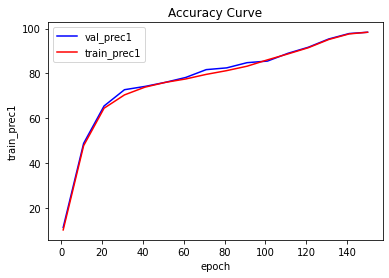

In [28]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r').set_title('Accuracy Curve')

Text(0.5, 1.0, 'Loss Curve')

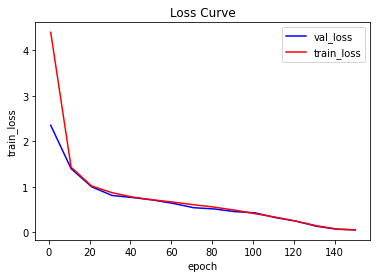

In [29]:
sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r').set_title('Loss Curve')

# Test Accuracy

In [5]:
base_model = resnet50()
base_model.fc = nn.Sequential(
    base_model.fc,
    nn.Linear(base_model.fc.out_features, 10), 
)
checkpoint_dict = ch.load('/home/pstefanou/cifar-10-resnet/7c16f712-a21b-40f6-8fb9-e90ef4be2908/checkpoint.pt.best')
base_model.load_state_dict(checkpoint_dict['model'])

<All keys matched successfully>

In [6]:
test_store = store.Store(args.out_dir)
results = train.eval_model(args, base_model, test_loader, test_store)
results

{'test_prec1': tensor(86.6400, device='cuda:0'),
 'test_loss': 0.5249435813903809,
 'time': 3.204224109649658}